In [1]:
import os
os.chdir("../")
with open('run/settings.py', 'r') as file:
    exec(file.read())

Random seed set to 333
using device:  cpu


# Configuration (customizable)

In [2]:
# (customize) configs
overwrite = False
model_name = 'nicu_mixture3' 
text_config['cl']['die7d'] = True # udpate text_config here if needed
text_config['ts']['succ_unc'] = False
# model_name = model_name + "___" + "_".join(get_true_components(text_config))

update_config(
    
    # Eval settings (clip)
    # ts2txt
    y_col = 'description_succ_inc',
    y_levels = ['High amount of consecutive increases.', 'Moderate amount of consecutive increases.', 'Low amount of consecutive increases.'],
    y_pred_levels = ['High amount of consecutive increases.', 'Moderate  amount of consecutive increases.', 'Low amount of consecutive increases.'],
    # txt2ts
    txt2ts_y_cols = ['description_succ_inc', 'description_histogram', 'description_ts_event_binary'],
    
    
    # Data settings
    text_col = 'ts_description', #'ts_description',
    downsample = True,
    downsample_size = 20000,
    downsample_levels = ['High amount of consecutive increases.', 'Moderate amount of consecutive increases.', 'Low amount of consecutive increases.'],
    custom_target_cols = ['description_succ_inc', 'description_histogram', 'description_ts_event_binary', 'label'], #  description_ts_event_binary 'description_succ_unc', 
    
    
    # Model settings
    model_name = model_name,
    **{'3d': False},  # Add this line
    embedded_dim = 512,
    concat_embeddings = False,
    clip_mu = True,
    variational = True,
    train_type = 'joint', # or 'vae', 'clip'
    clip_target_type = 'by_target', # or 'by_label'
    
    # Train settings
    batch_size = 512,
    init_lr = 1e-5,
    patience = 100,
    alpha = 1/500,
    num_saves = 20,
    num_epochs = 500,
    
    # Text configuration
    text_config = text_config
)
config_dict = get_config_dict()


# Data

In [3]:
# change data preparation for a given experiment
with open('run/prepare_datasets/nicu.py', 'r') as file:
    exec(file.read())
# prepare model inputs
with open('run/inputs.py', 'r') as file:
    exec(file.read())



Sample of patients with positive labels:
VitalID
1018    8
5170    8
1835    8
2361    8
2791    8
dtype: int64


Processing descriptions: 100%|██████████| 131/131 [00:22<00:00,  5.76it/s]


replace 'text' with:  ts_description
text
Moderate variability. Moderate amount of consecutive increases. No events.    25032
High variability. Moderate amount of consecutive increases. No events.         8407
Low variability. Low amount of consecutive increases. No events.               7497
Low variability. Moderate amount of consecutive increases. No events.          6267
High variability. High amount of consecutive increases. No events.             5162
Name: count, dtype: int64

Sample of patients with positive labels:
TestID
508     8
707     8
1903    8
817     8
1414    7
dtype: int64


Processing descriptions: 100%|██████████| 123/123 [00:18<00:00,  6.73it/s]


replace 'text' with:  ts_description
text
Moderate variability. Moderate amount of consecutive increases. No events.    22026
Low variability. Low amount of consecutive increases. No events.               9493
High variability. Moderate amount of consecutive increases. No events.         6287
High variability. High amount of consecutive increases. No events.             5965
Low variability. Moderate amount of consecutive increases. No events.          5838
Name: count, dtype: int64
After downsampling:
description_succ_inc
Moderate amount of consecutive increases.    20000
Low amount of consecutive increases.         11838
High amount of consecutive increases.        10352
Name: count, dtype: int64
After downsampling:
description_succ_inc
Moderate amount of consecutive increases.    18086
Low amount of consecutive increases.          6582
High amount of consecutive increases.         5930
Name: count, dtype: int64


final distribution of text prediction
description_succ_inc
Moderate am

# Model (customizable)

In [4]:
# customize encoder and decoder here. 
ts_encoder = MultiCNNEncoder(ts_dim = ts_f_dim.shape[1],
                             output_dim=config_dict['embedded_dim'],
                             kernel_sizes=[150, 100, 50, 10],
                             hidden_num_channel=16,
                             dropout=0)
ts_decoder = TransformerDecoder(ts_dim = ts_f_dim.shape[1], output_dim = config_dict['embedded_dim']+2, 
                 nhead = 6,
                 num_layers = 6,
                 dim_feedforward = 512,
                 dropout = 0.0)
text_encoder = TextEncoderMultiCNN(text_dim = tx_f_dim.shape[1],
                                   output_dim=config_dict['embedded_dim'],
                                   kernel_sizes=[768, 384, 192],  # Different context windows
                                   hidden_num_channel=16,
                                   dropout=0.0)
# overwrite = False
with open('run/model.py', 'r') as file:
    exec(file.read())


Layer (type:depth-idx)                                                      Param #
VITAL                                                                       1
├─TSVAEEncoder: 1-1                                                         --
│    └─LocalNorm: 2-1                                                       --
│    └─MultiCNNEncoder: 2-2                                                 512
│    │    └─ModuleList: 3-1                                                 4,922,400
│    │    └─MultiheadAttention: 3-2                                         1,050,624
│    │    └─LayerNorm: 3-3                                                  1,024
│    └─Linear: 2-3                                                          262,656
│    └─Linear: 2-4                                                          262,656
├─TextEncoder: 1-2                                                          --
│    └─TextEncoderMultiCNN: 2-5                                             512
│    │    └─ModuleL

# Train

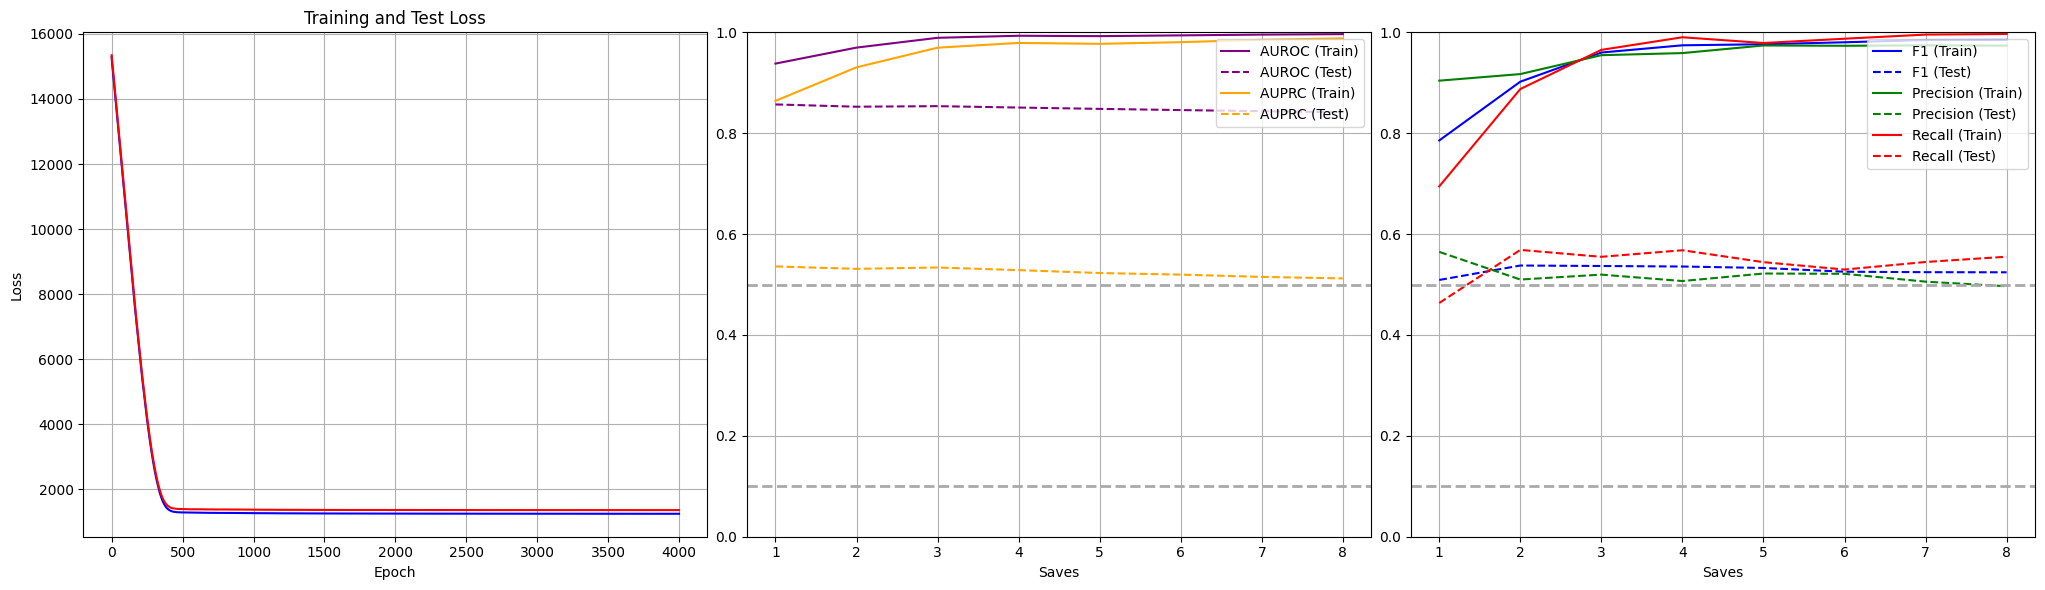

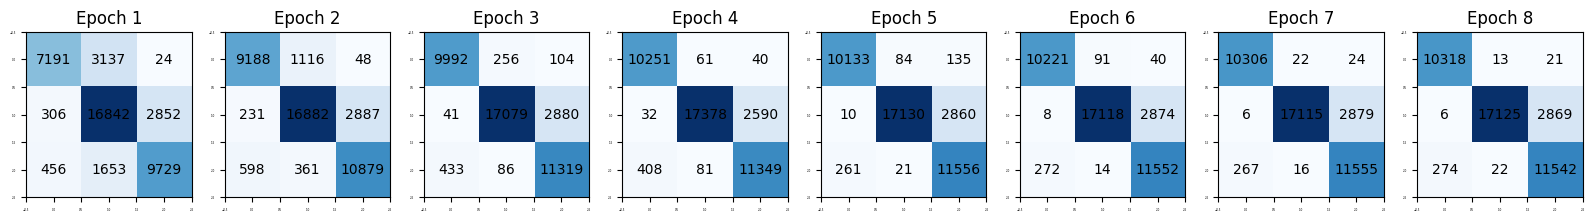

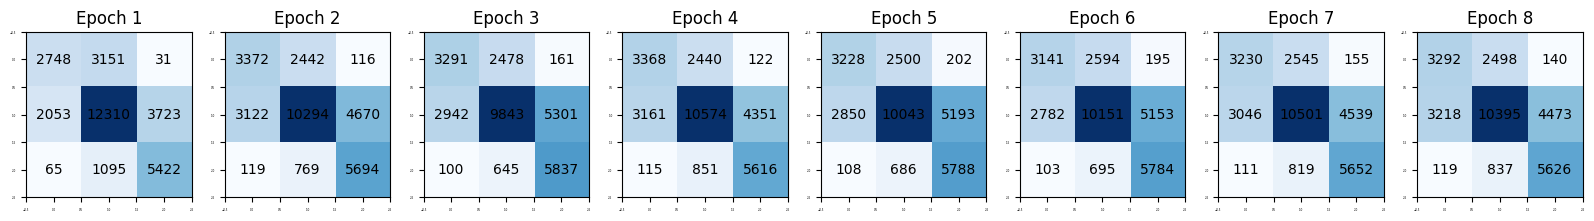

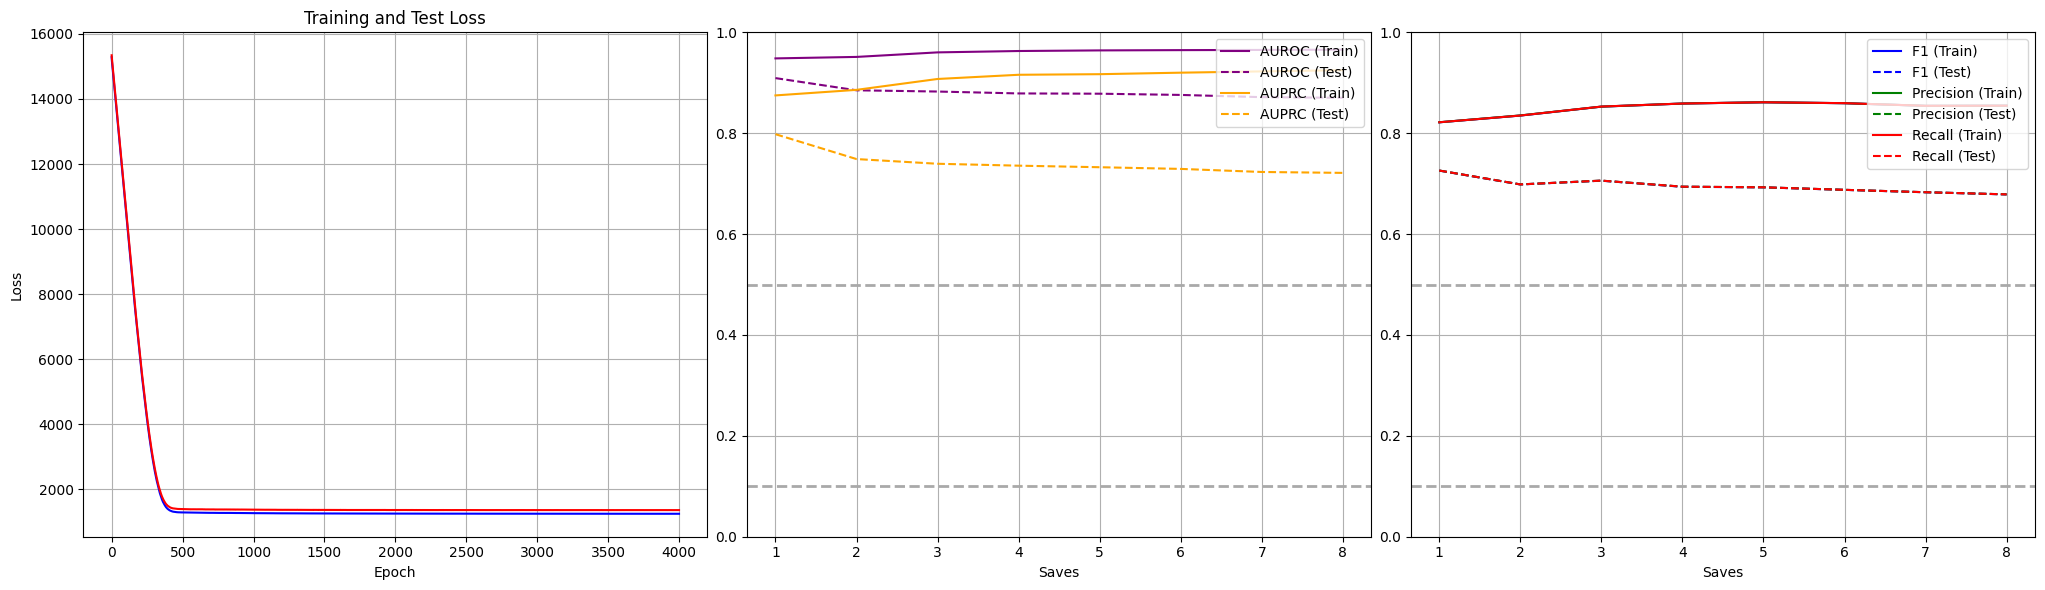

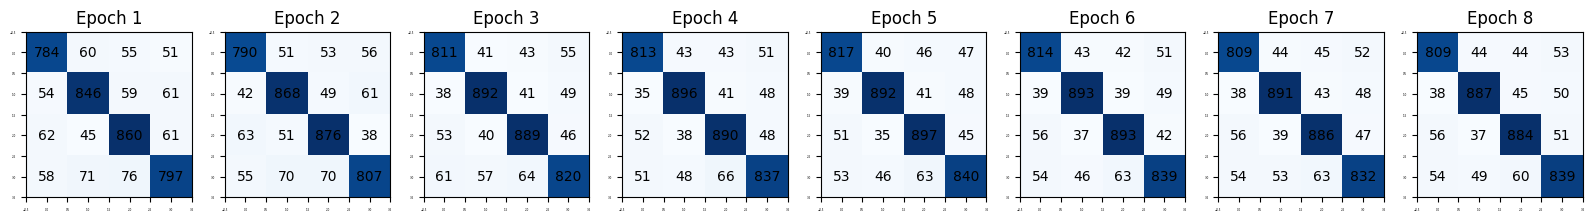

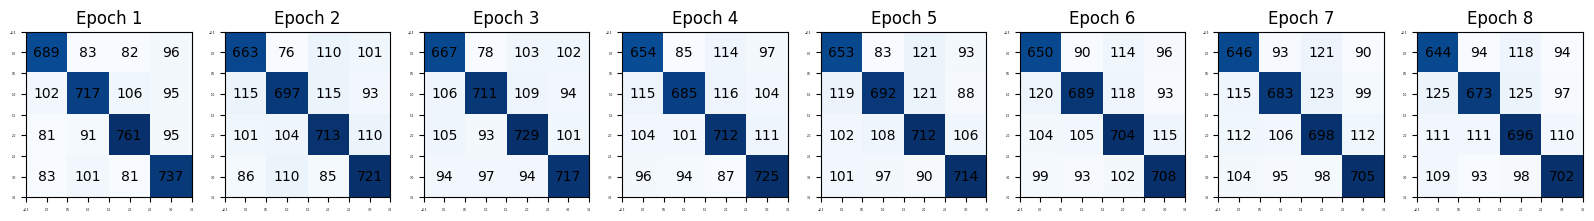

KeyboardInterrupt: 

In [5]:
# overwrite = False
# config_dict['train_type']='clip'
with open('run/train.py', 'r') as file:
    exec(file.read())


# Generation

0    High amount of consecutive increases.
Name: description_succ_inc, dtype: object


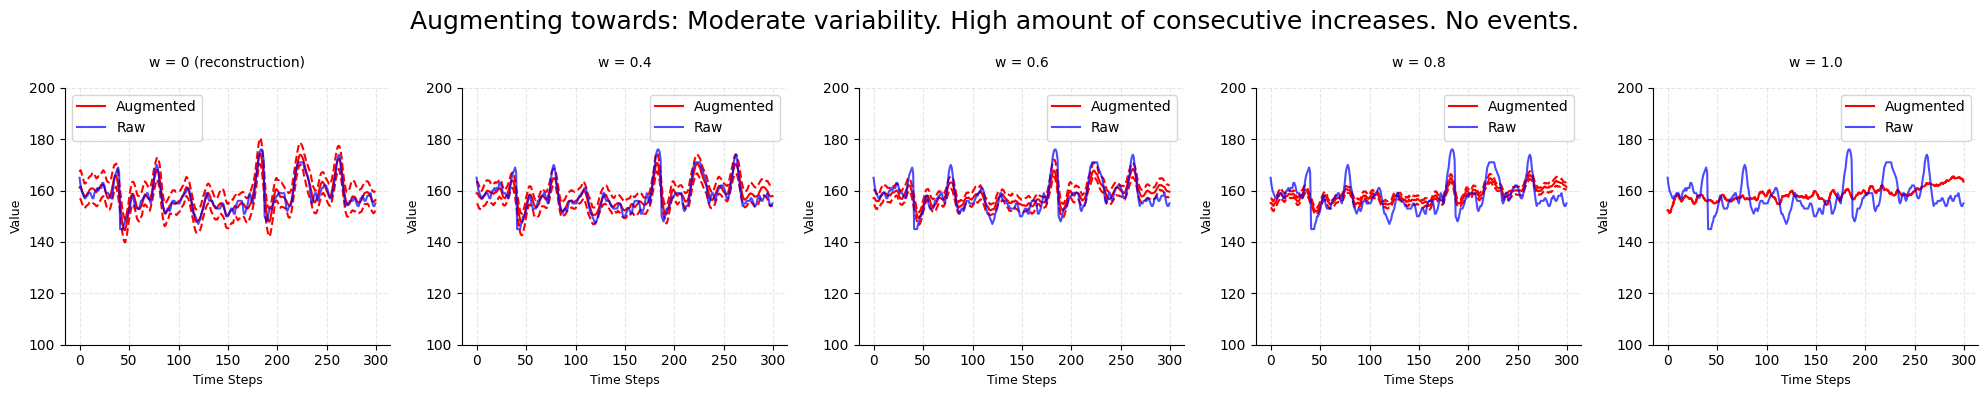

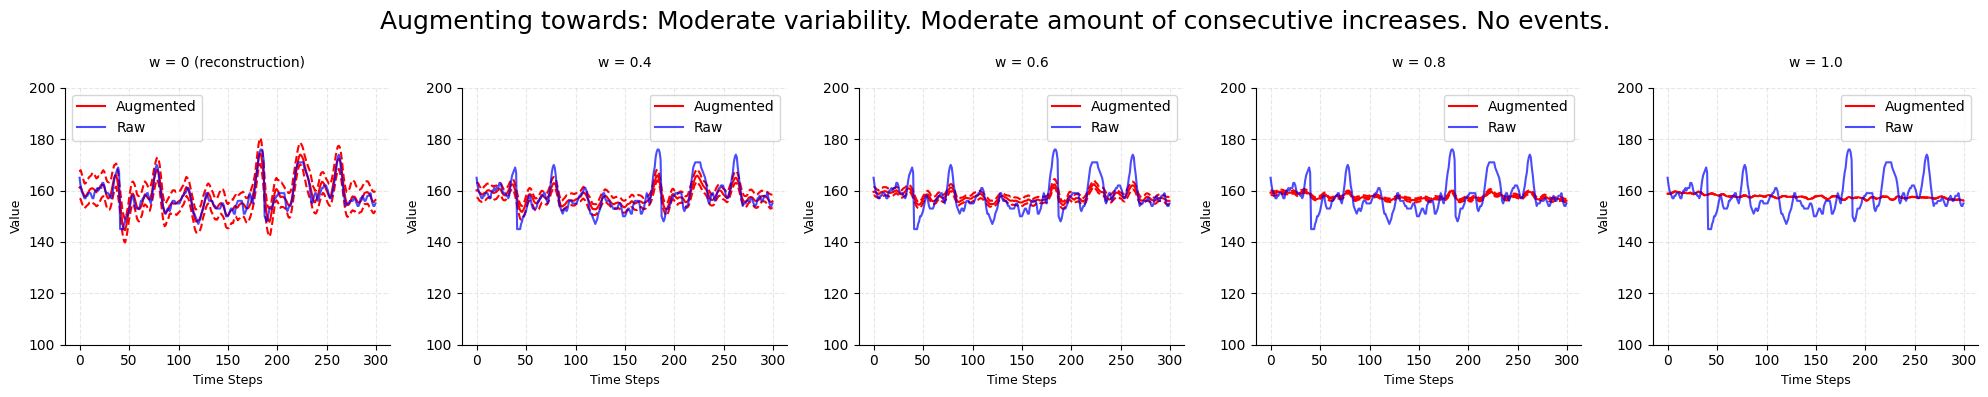

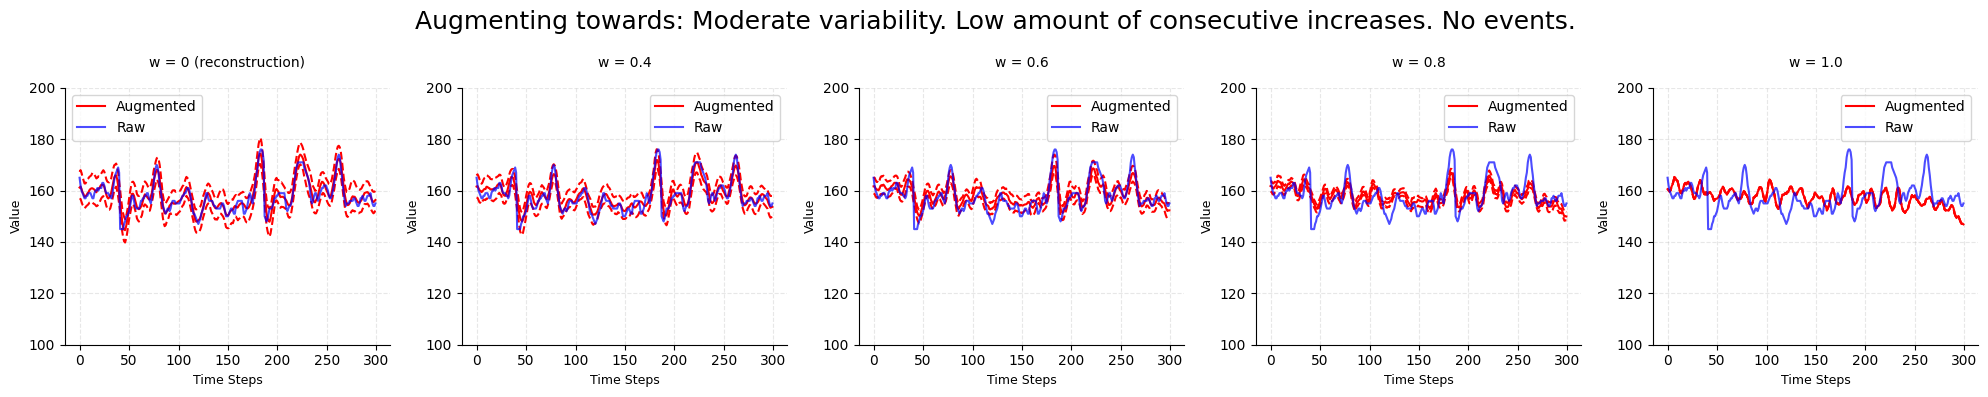

0    Moderate amount of consecutive increases.
Name: description_succ_inc, dtype: object


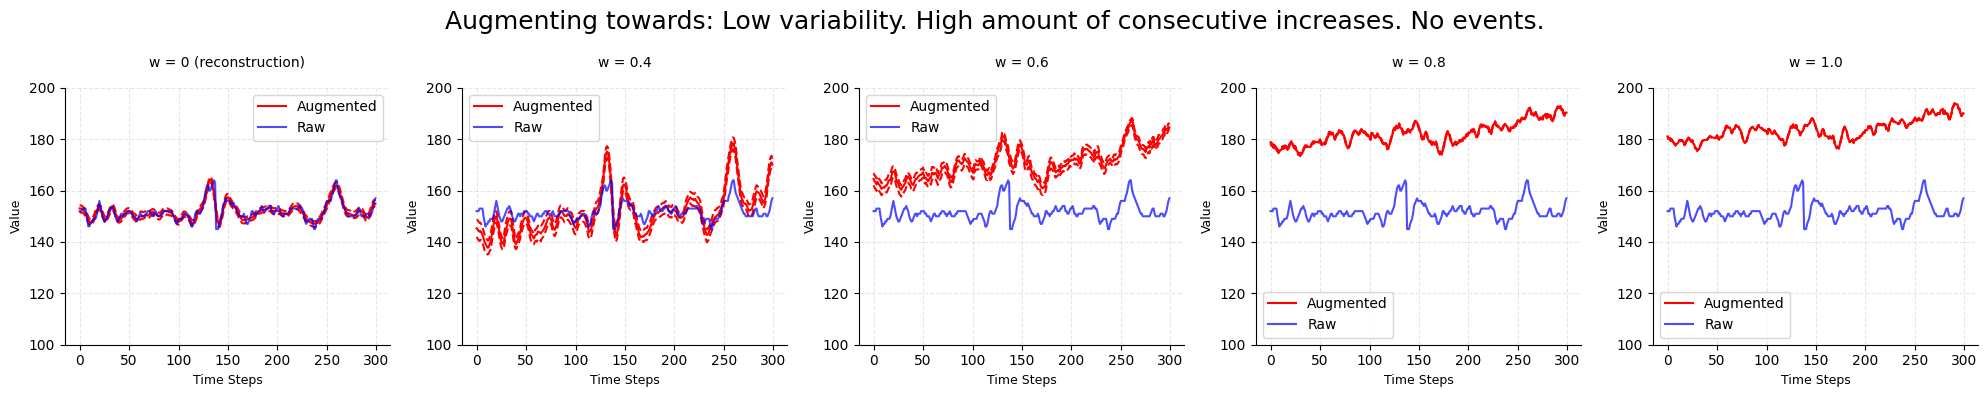

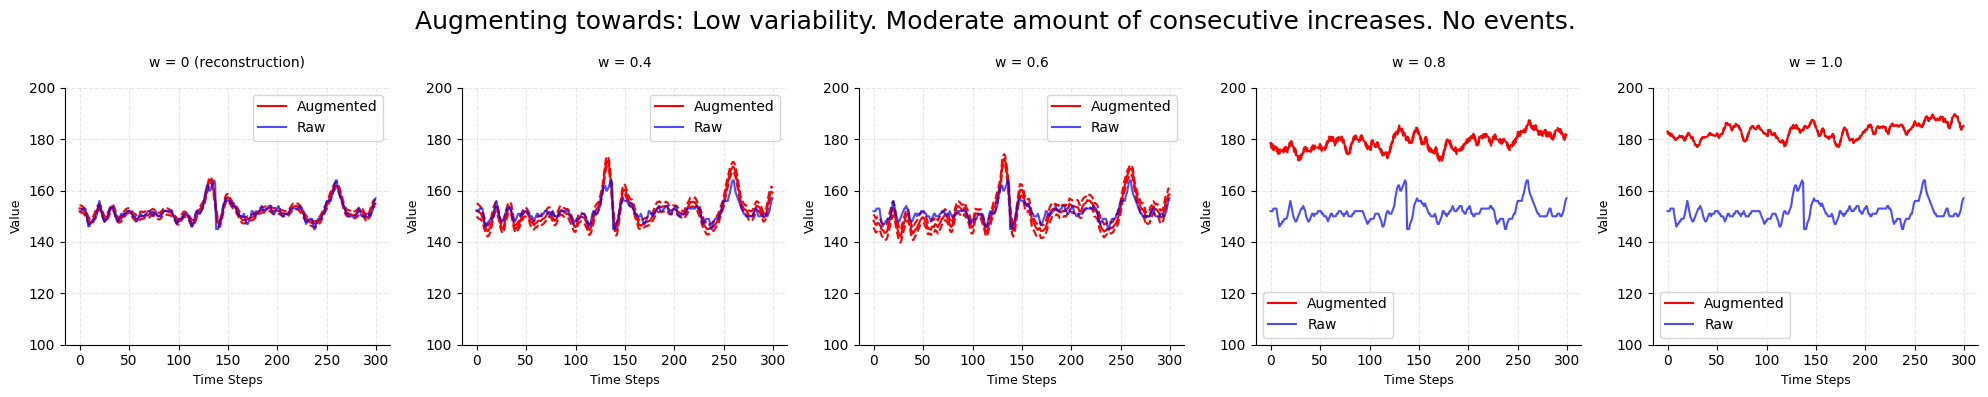

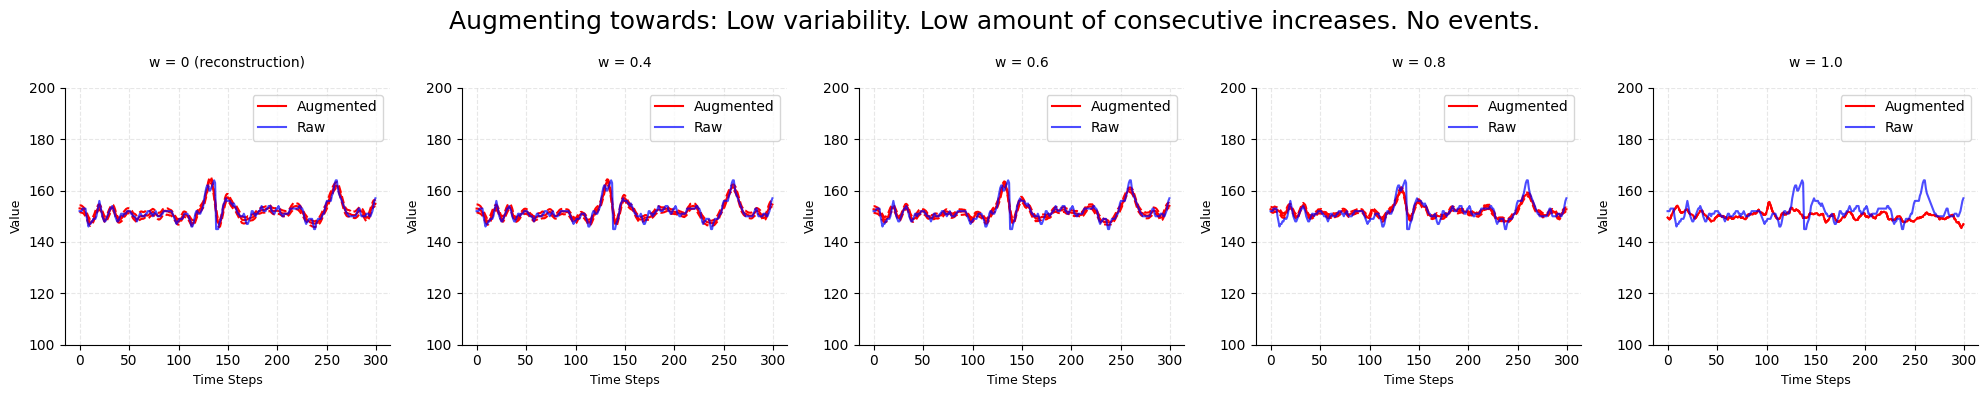

0    Low amount of consecutive increases.
Name: description_succ_inc, dtype: object


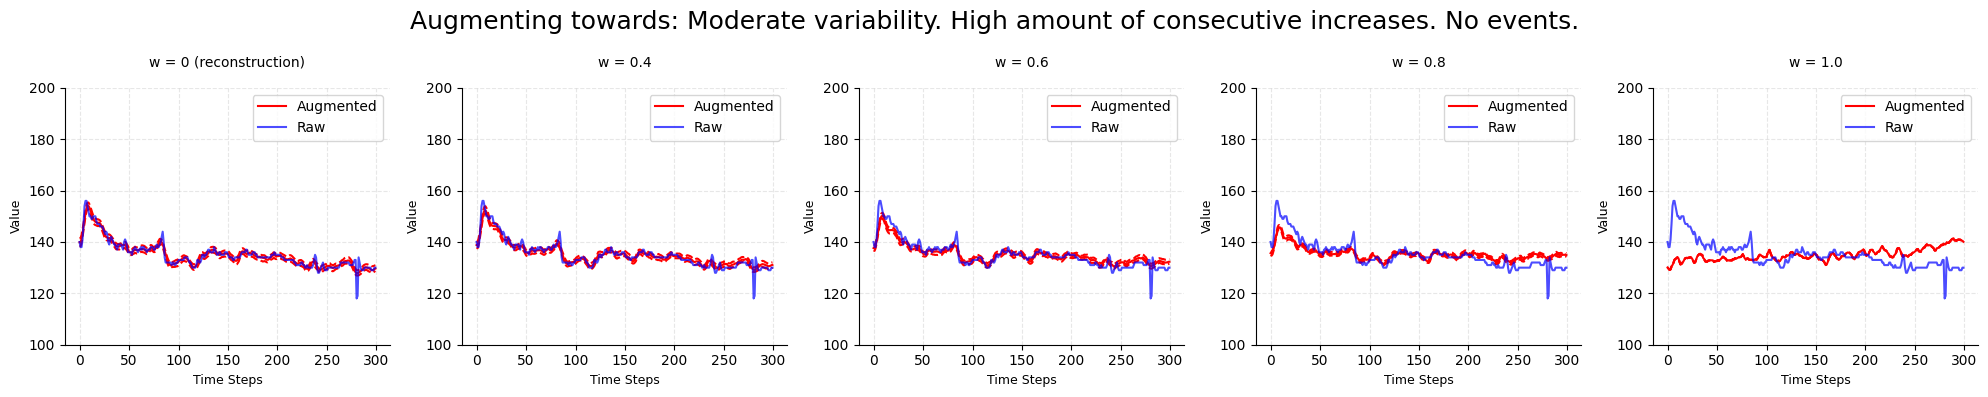

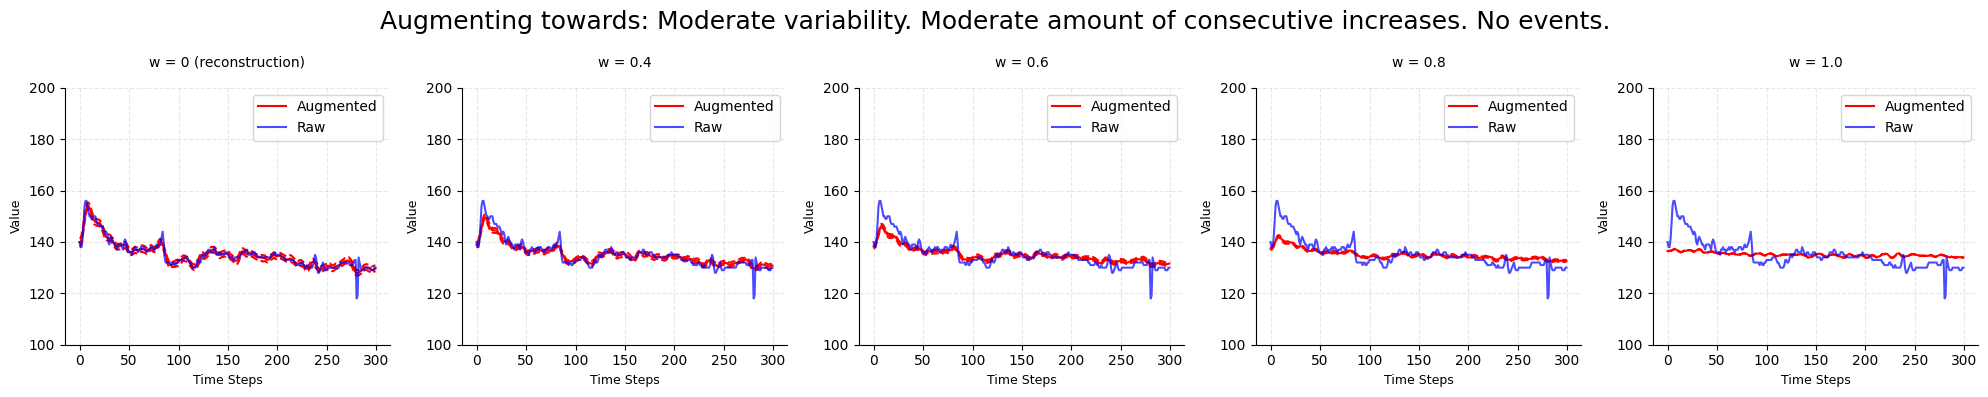

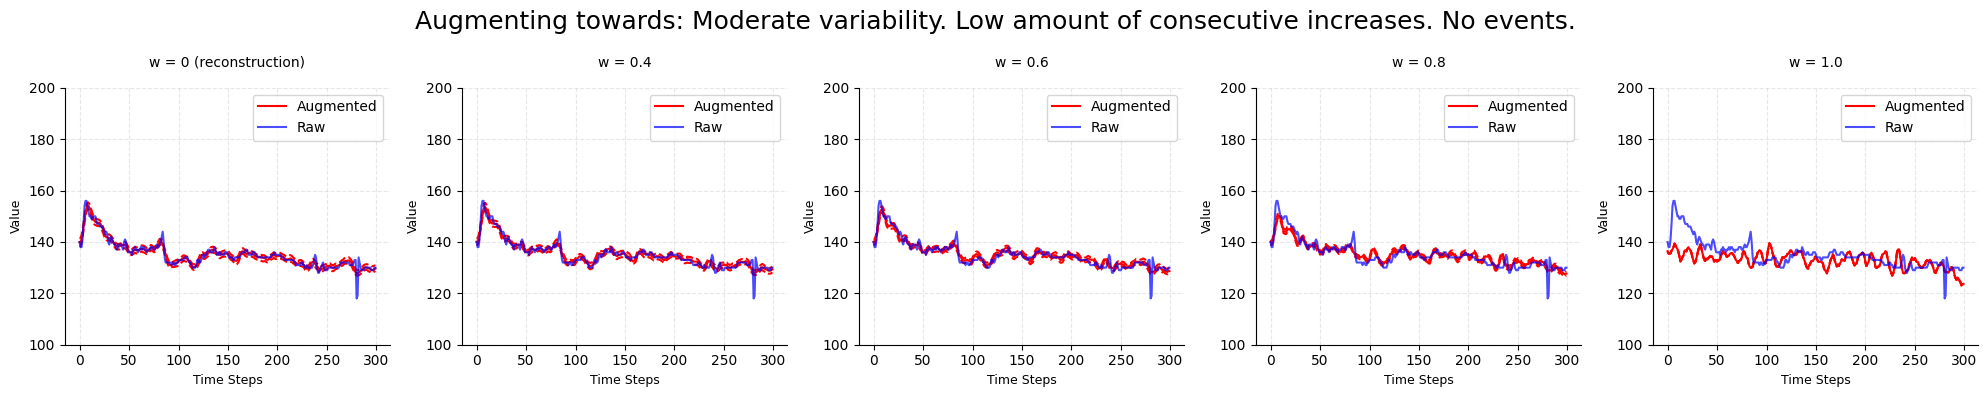

0    Moderate variability.
Name: description_histogram, dtype: object


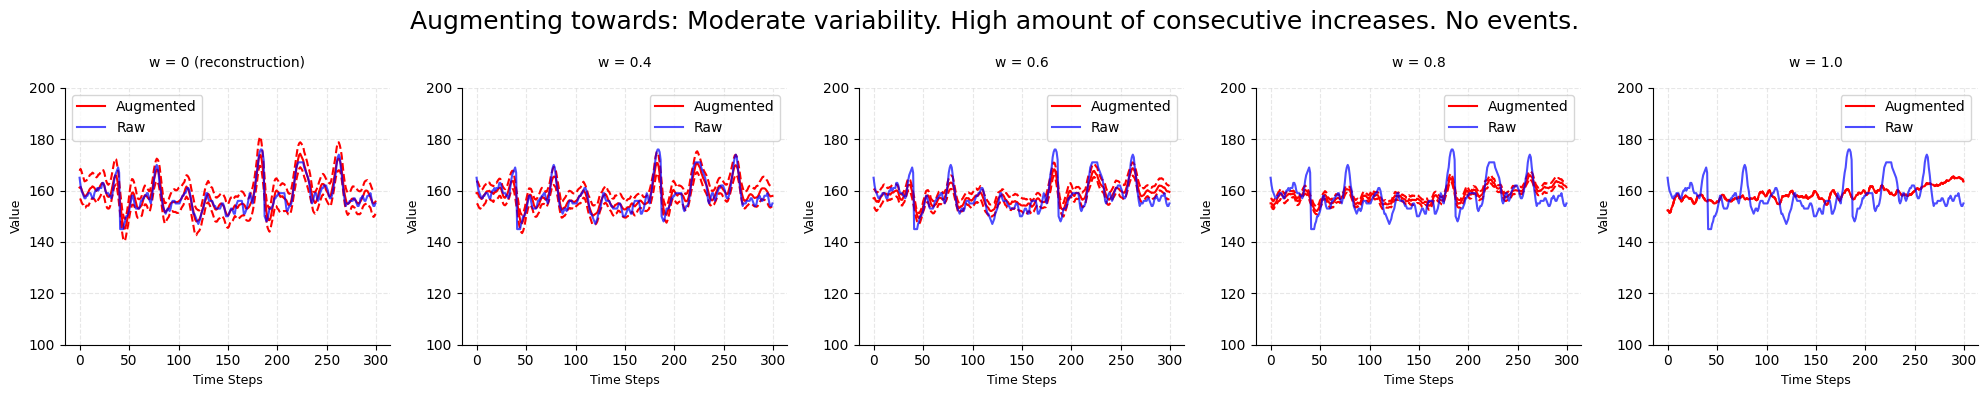

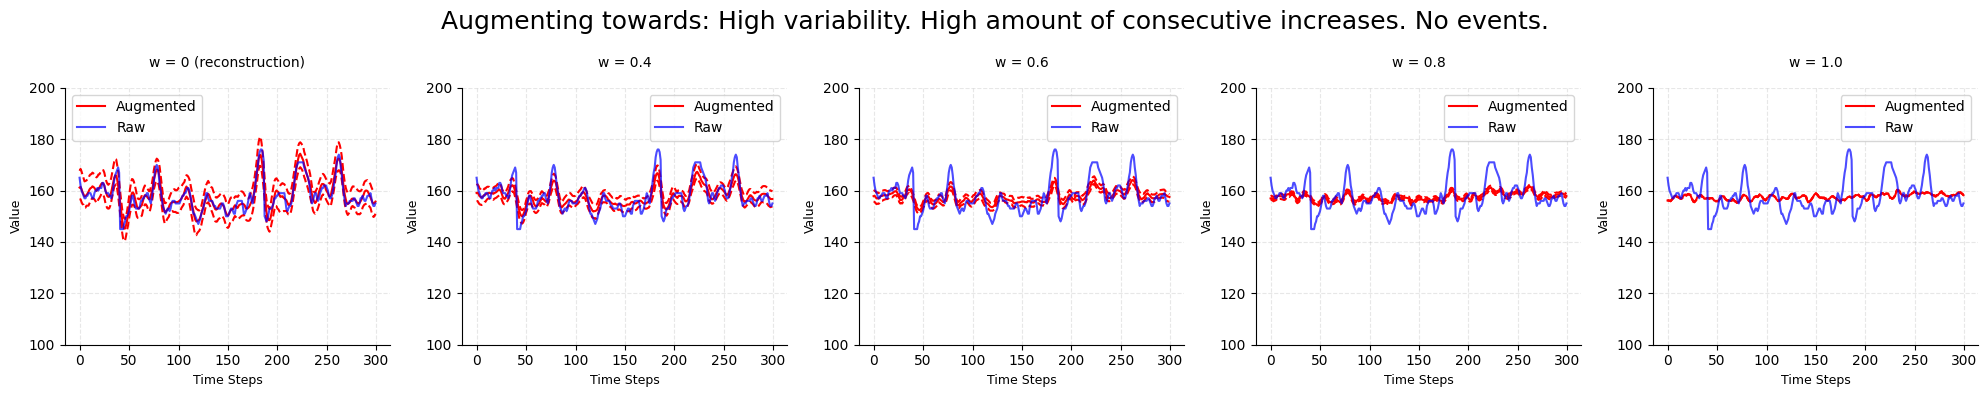

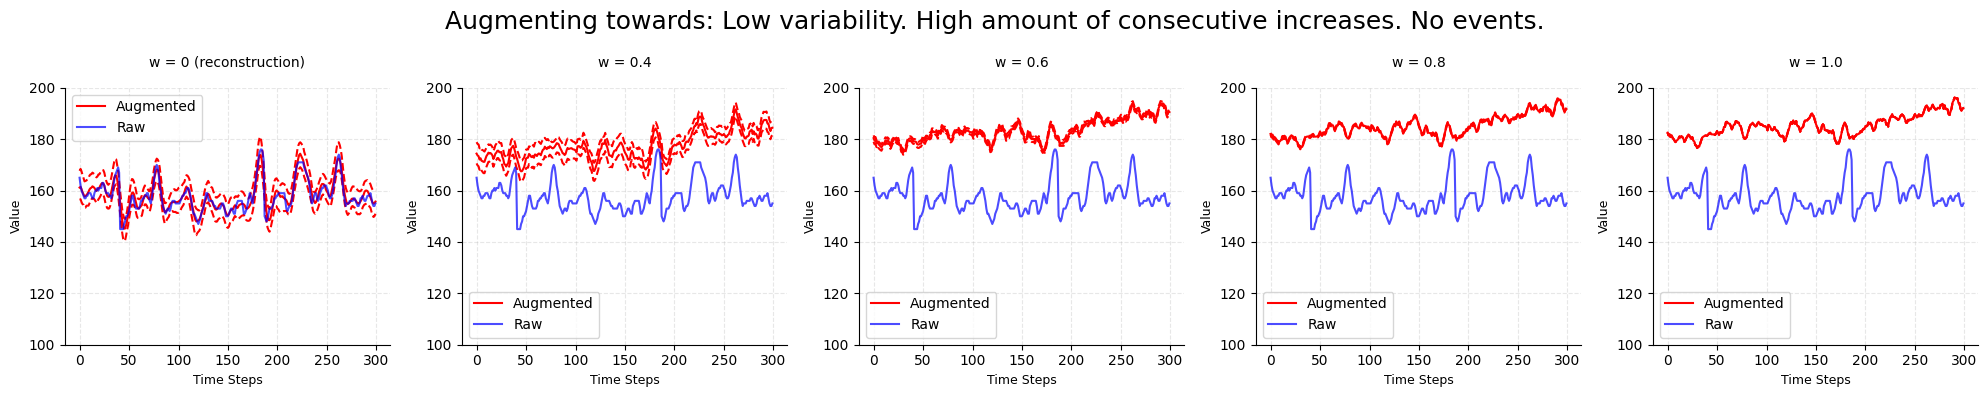

0    High variability.
Name: description_histogram, dtype: object


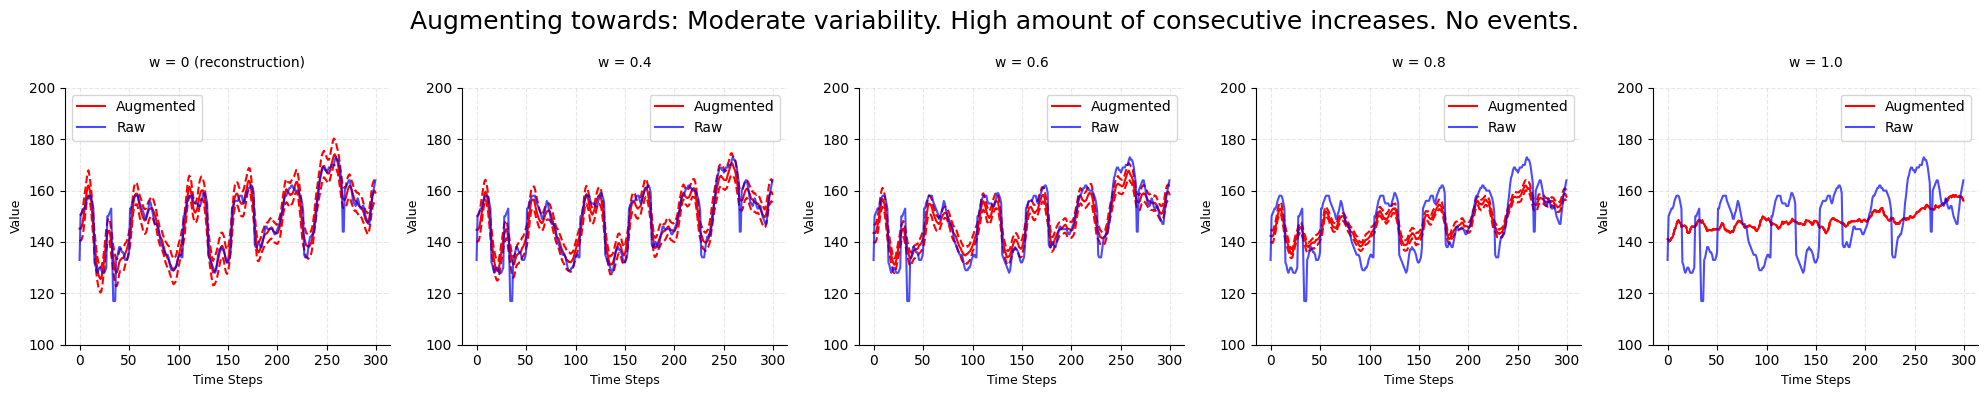

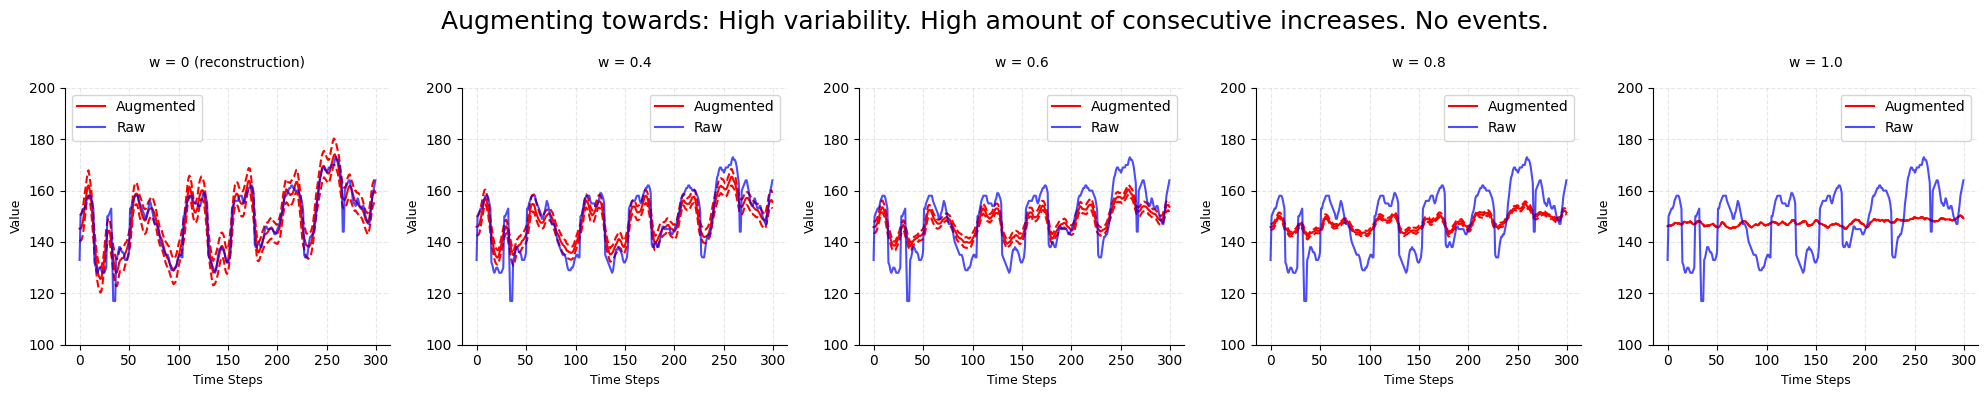

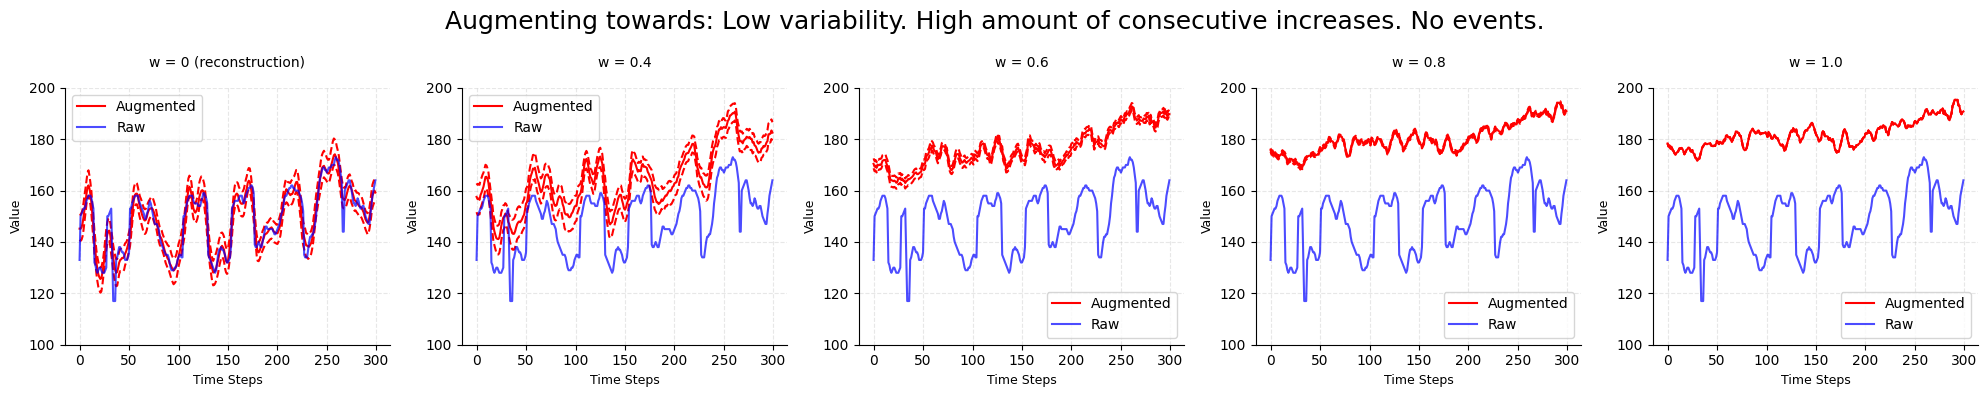

0    Low variability.
Name: description_histogram, dtype: object


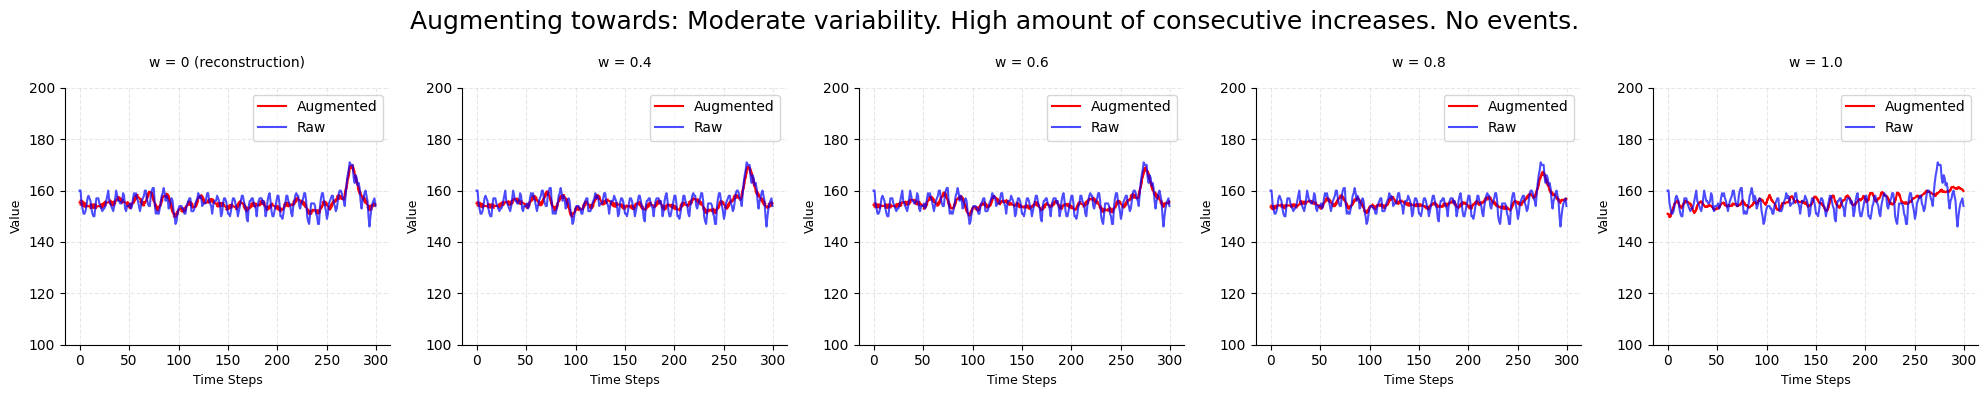

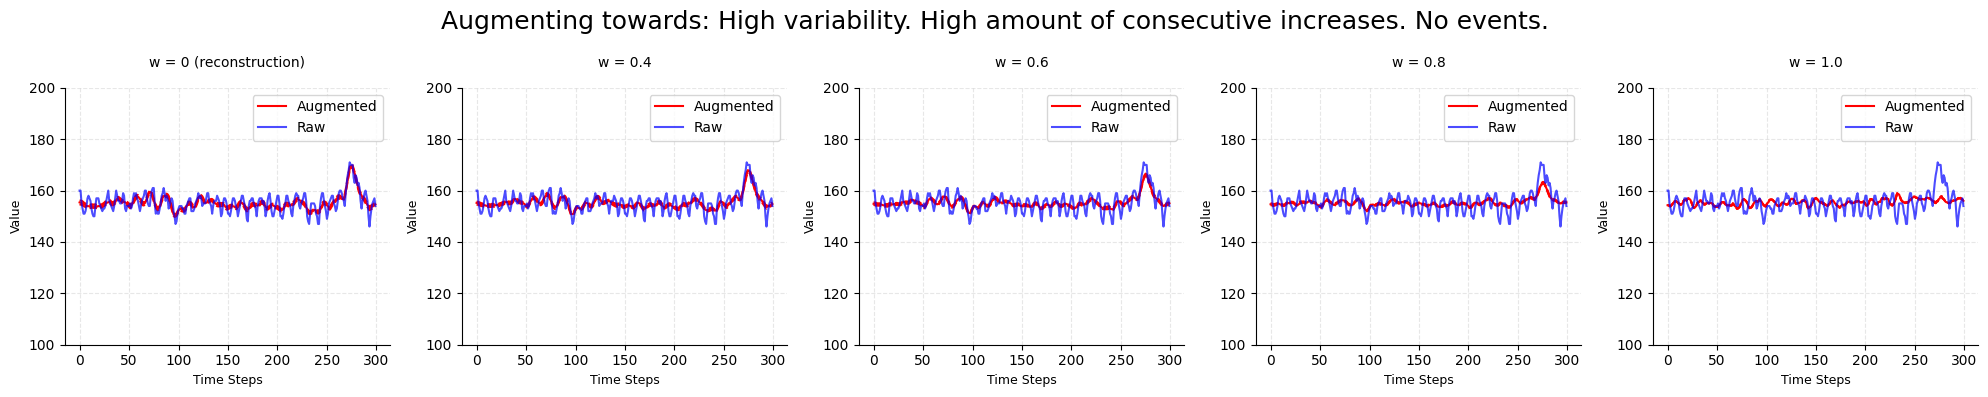

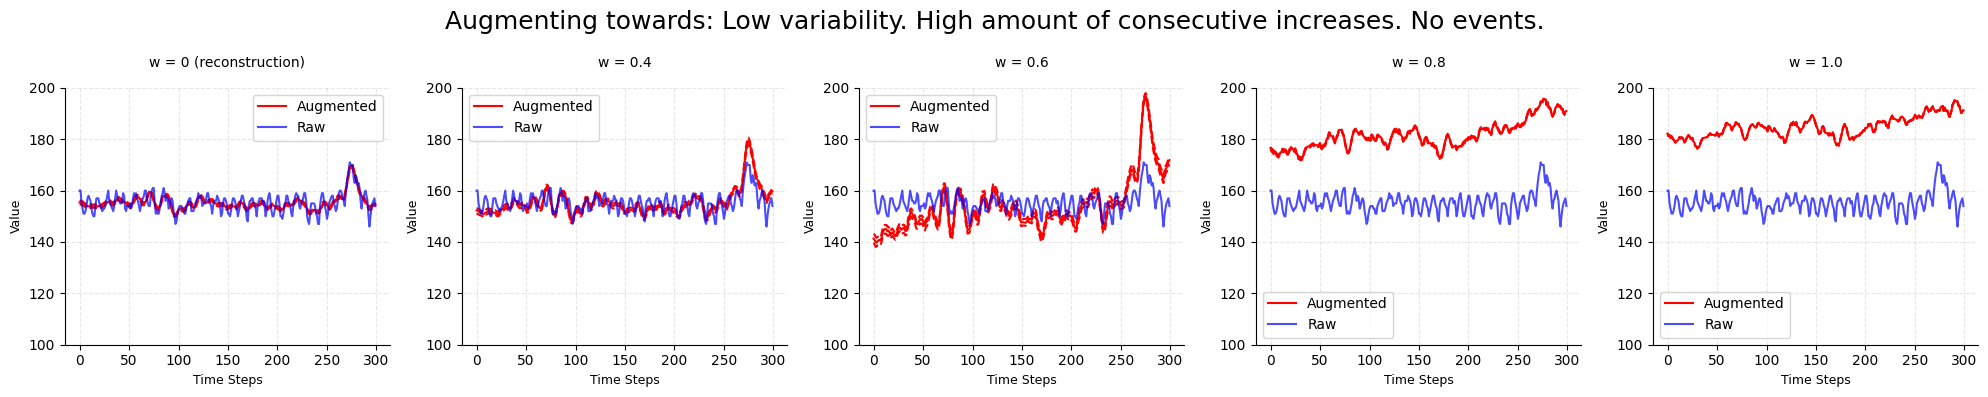

0    No events.
Name: description_ts_event_binary, dtype: object


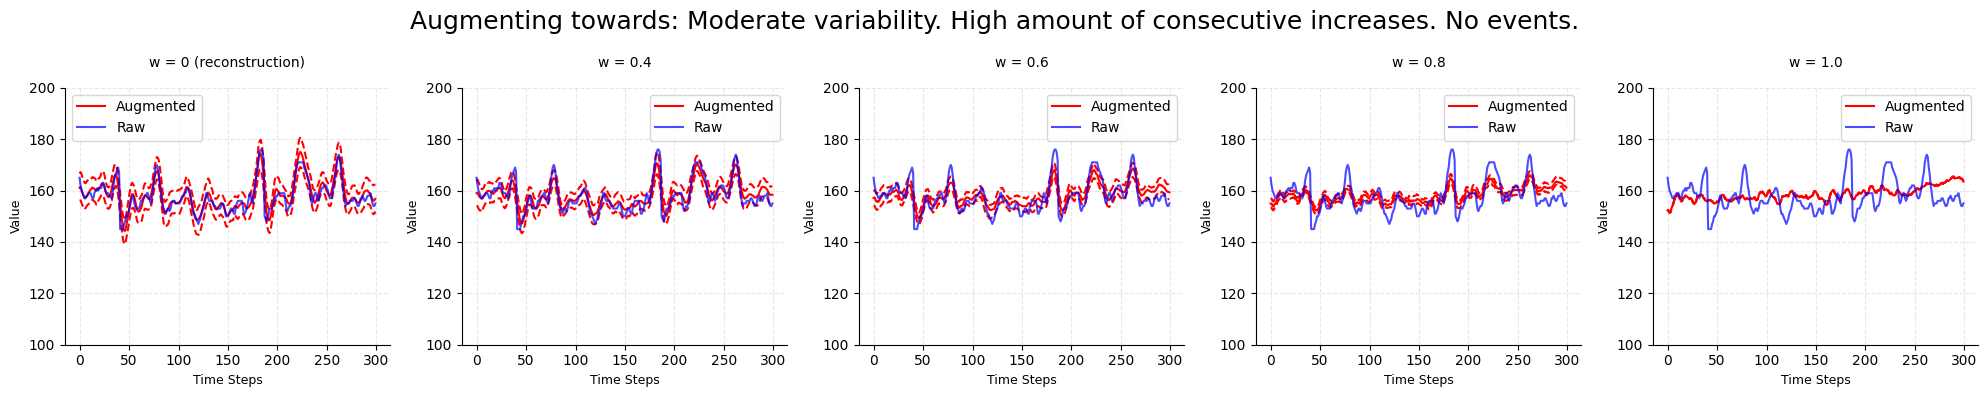

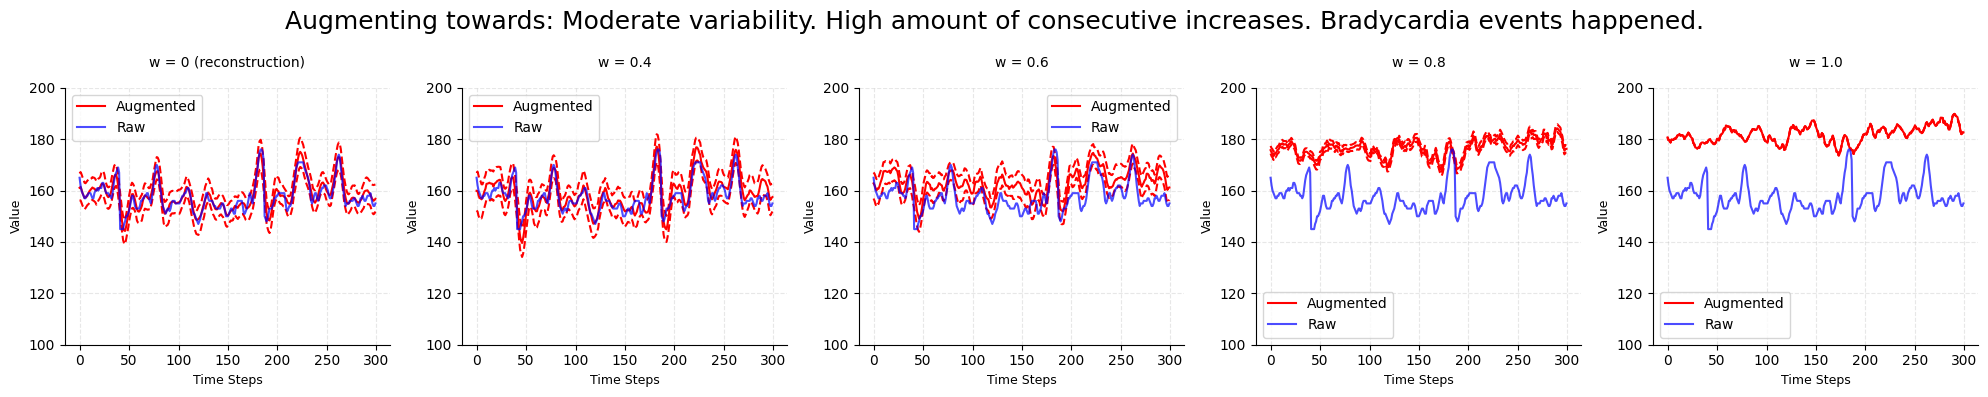

0    Bradycardia events happened.
Name: description_ts_event_binary, dtype: object


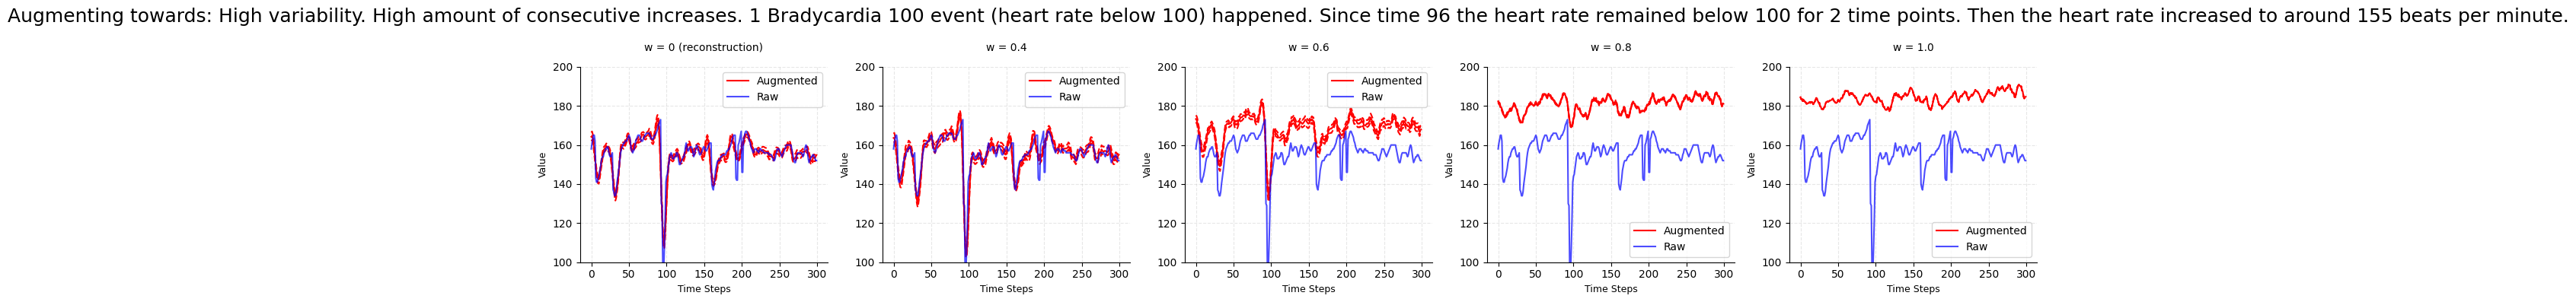

In [6]:
tid=0
viz_generation_conditional(df_test, model, config_dict, tid=tid, sampling=True, b=100, ep=100, ylims=(100, 200))

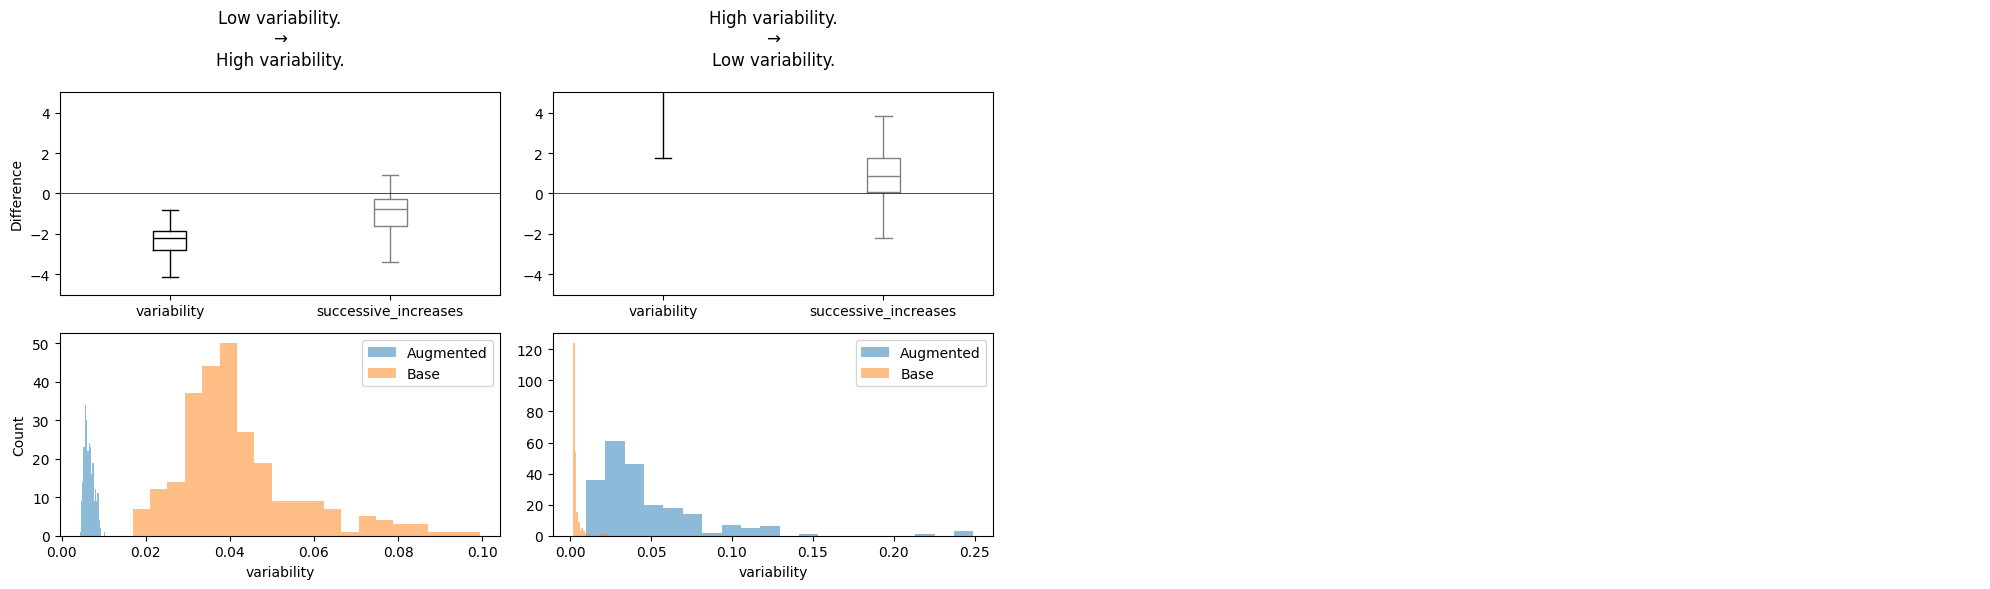

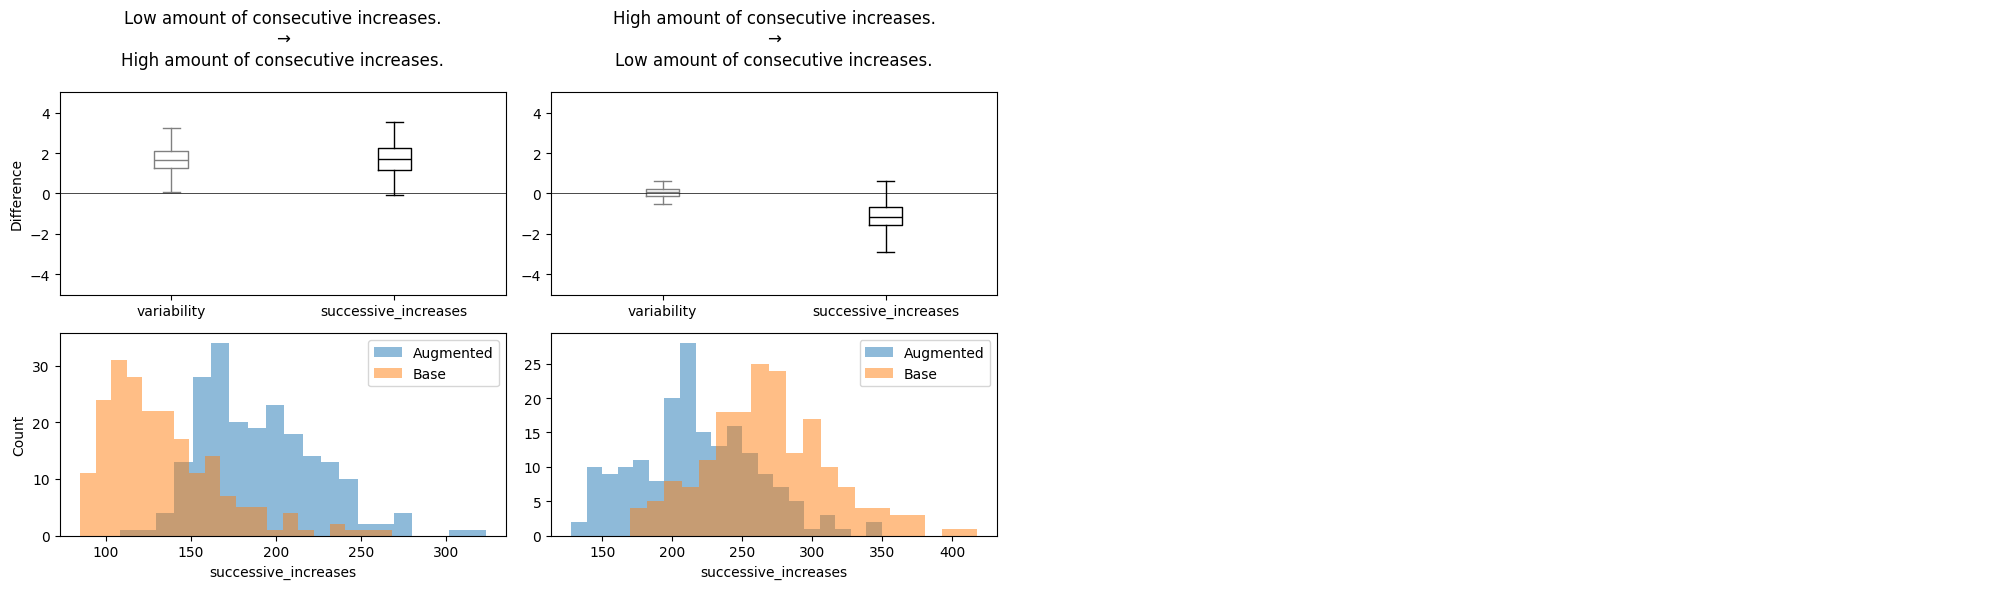

In [ ]:
# Math eval
if overwrite or (not os.path.exists(output_dir+'/df_stats_all.pt.gz')):
    # calculate the properties of the generated time series
    df = df_test.sample(1000)
    df_stats_all = eval_math_properties(df, model, config_dict, type = "conditional", w = 0.8)
    
    # Save using PyTorch with gzip compression
    buffer = io.BytesIO()
    torch.save(df_stats_all, buffer)
    with gzip.open(output_dir+'/df_stats_all.pt.gz', 'wb') as f:
        f.write(buffer.getvalue())
else:
    # Load compressed file
    with gzip.open(output_dir+'/df_stats_all.pt.gz', 'rb') as f:
        buffer = io.BytesIO(f.read())
        df_stats_all = torch.load(buffer, map_location=device)

        # Define the base augmentation pairs
base_aug_dict = {'variability': [("Low variability.", "High variability."),
                                ('High variability.', "Low variability.")],
                'successive_increases': [("Low amount of consecutive increases.", "High amount of consecutive increases."),
                                ('High amount of consecutive increases.', "Low amount of consecutive increases.")]
                    }

df_stats = eng_math_diff_multiple(df_stats_all, base_aug_dict, metrics=['variability', 'successive_increases'])


In [6]:
overwrite = False
# argument dictionary {y_col:conditions}
args0 = {'description_succ_inc': None,
        'description_histogram': None,
        'description_ts_event_binary': None
        }

args1 = {'description_succ_inc': [('description_histogram', "Low variability."), ('description_ts_event_binary', "No events.")],
        'description_histogram': [('description_succ_inc', "Moderate amount of consecutive increases."), ('description_ts_event_binary', "No events.")],
        'description_ts_event_binary': [('description_succ_inc', "Moderate amount of consecutive increases."), ('description_histogram', "Moderate variability.")]
        }

args_ls = [args0, args1]
filename = output_dir+'/df_dists_all.pt.gz'
if overwrite or (not os.path.exists(filename)):
    res_all = []
    for args in args_ls:
        dists_dict = {}
        for y_col in args.keys():
            print(y_col)
            df_dists = eval_ts_distances(df_test,
                                        model, 
                                        config_dict, 
                                        w = 0.8,
                                        y_col = y_col,
                                        conditions = args[y_col],
                                        b = 500)
            dists_dict[y_col] = df_dists

        # Save using PyTorch with gzip compression
        res = {'args':args, 'dists_dict':dists_dict}
        res_all.append(res)

    buffer = io.BytesIO()
    torch.save(res_all, buffer)
    with gzip.open(filename, 'wb') as f: f.write(buffer.getvalue())
else:
    # Load compressed file
    with gzip.open(filename, 'rb') as f:
        buffer = io.BytesIO(f.read())
        res_all = torch.load(buffer, map_location=device)



description_succ_inc


Calculating distances: 100%|██████████| 250000/250000 [00:24<00:00, 10104.52it/s]


description_histogram


Calculating distances: 100%|██████████| 250000/250000 [00:24<00:00, 10082.54it/s]


description_ts_event_binary


Calculating distances: 100%|██████████| 250000/250000 [00:24<00:00, 10074.91it/s]


description_succ_inc


Calculating distances: 100%|██████████| 250000/250000 [00:24<00:00, 10261.45it/s]


description_histogram


Calculating distances: 100%|██████████| 250000/250000 [00:24<00:00, 10044.76it/s]


description_ts_event_binary


Calculating distances: 100%|██████████| 250000/250000 [00:25<00:00, 9730.18it/s]


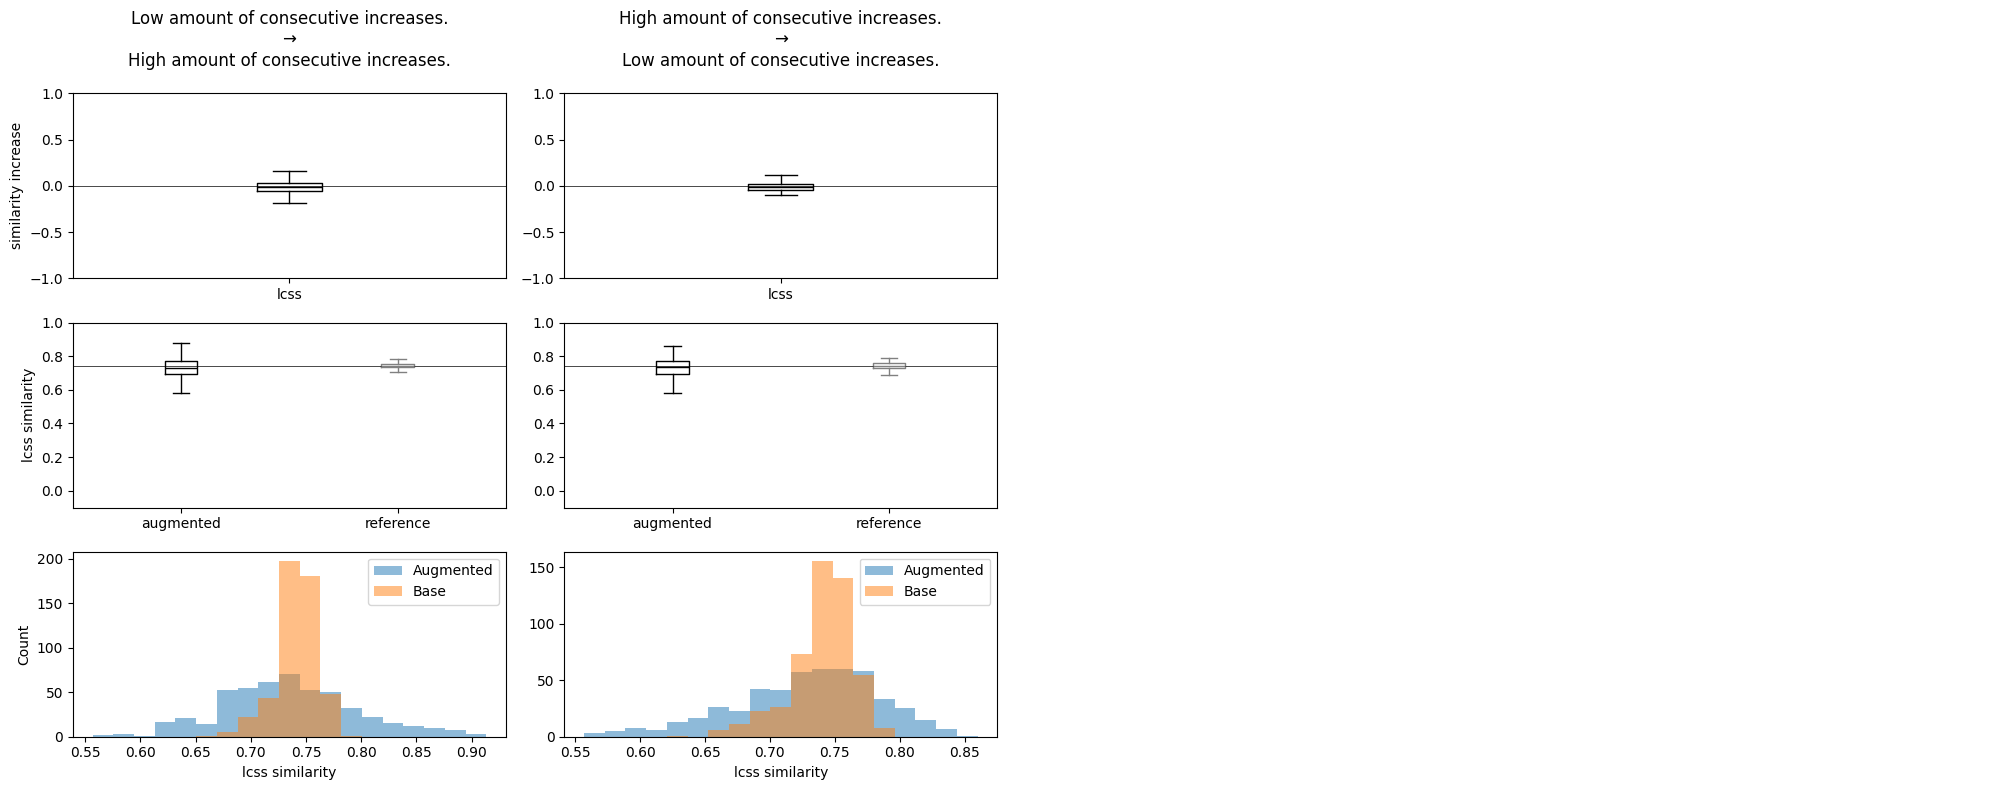

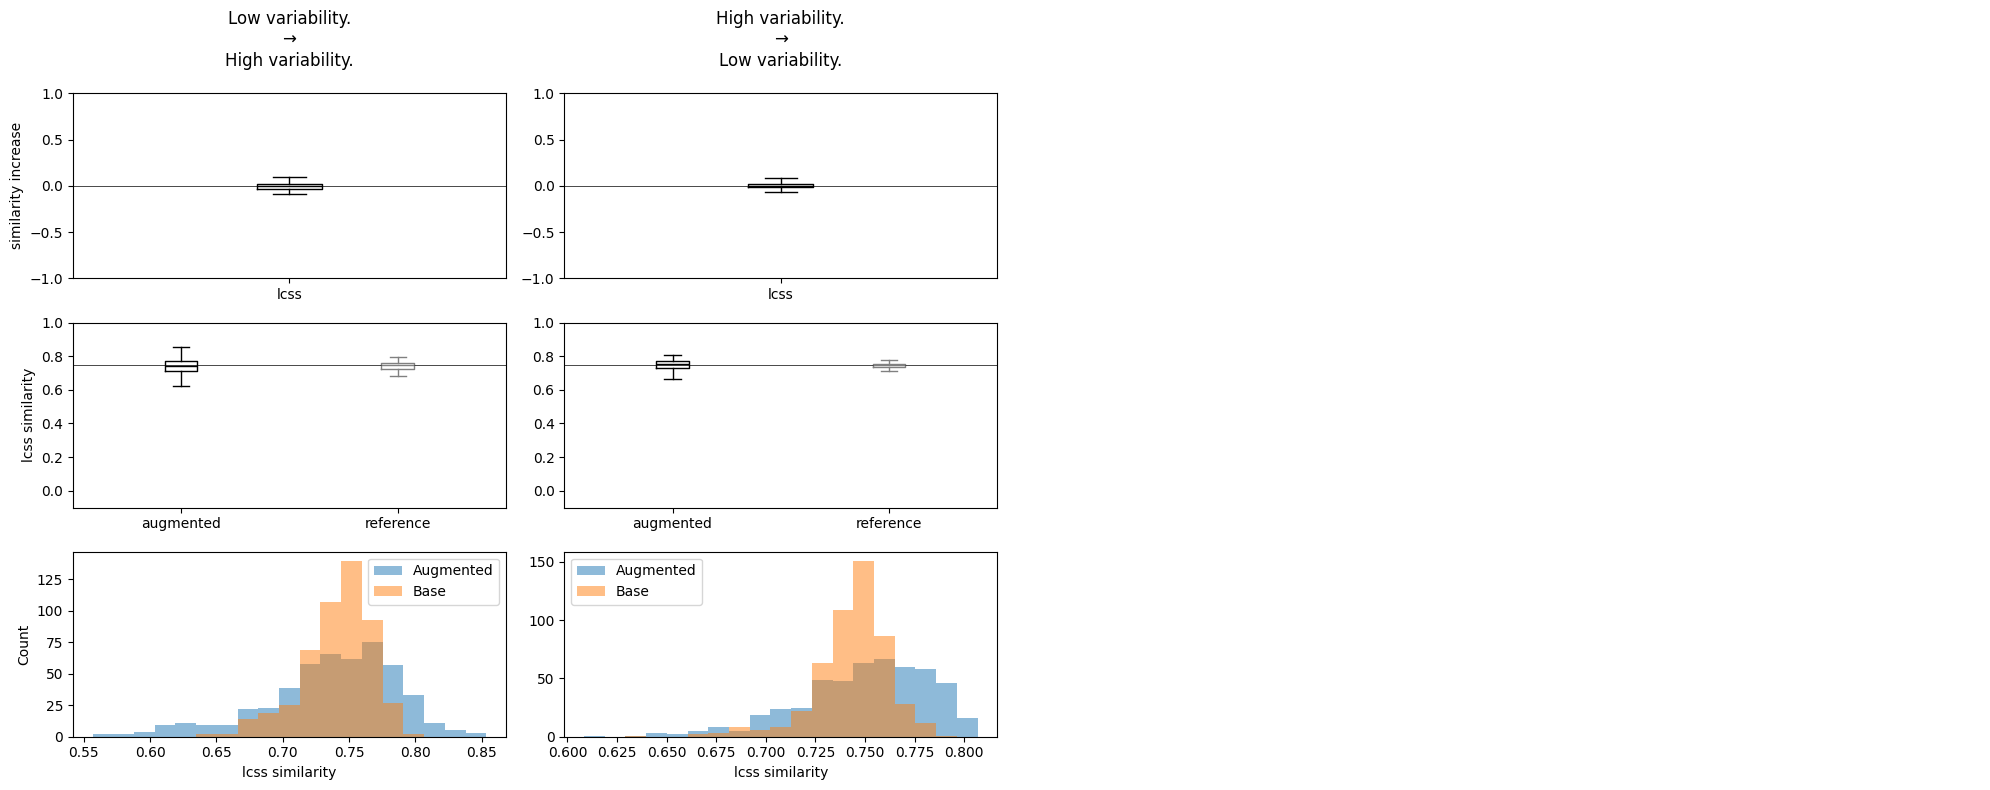

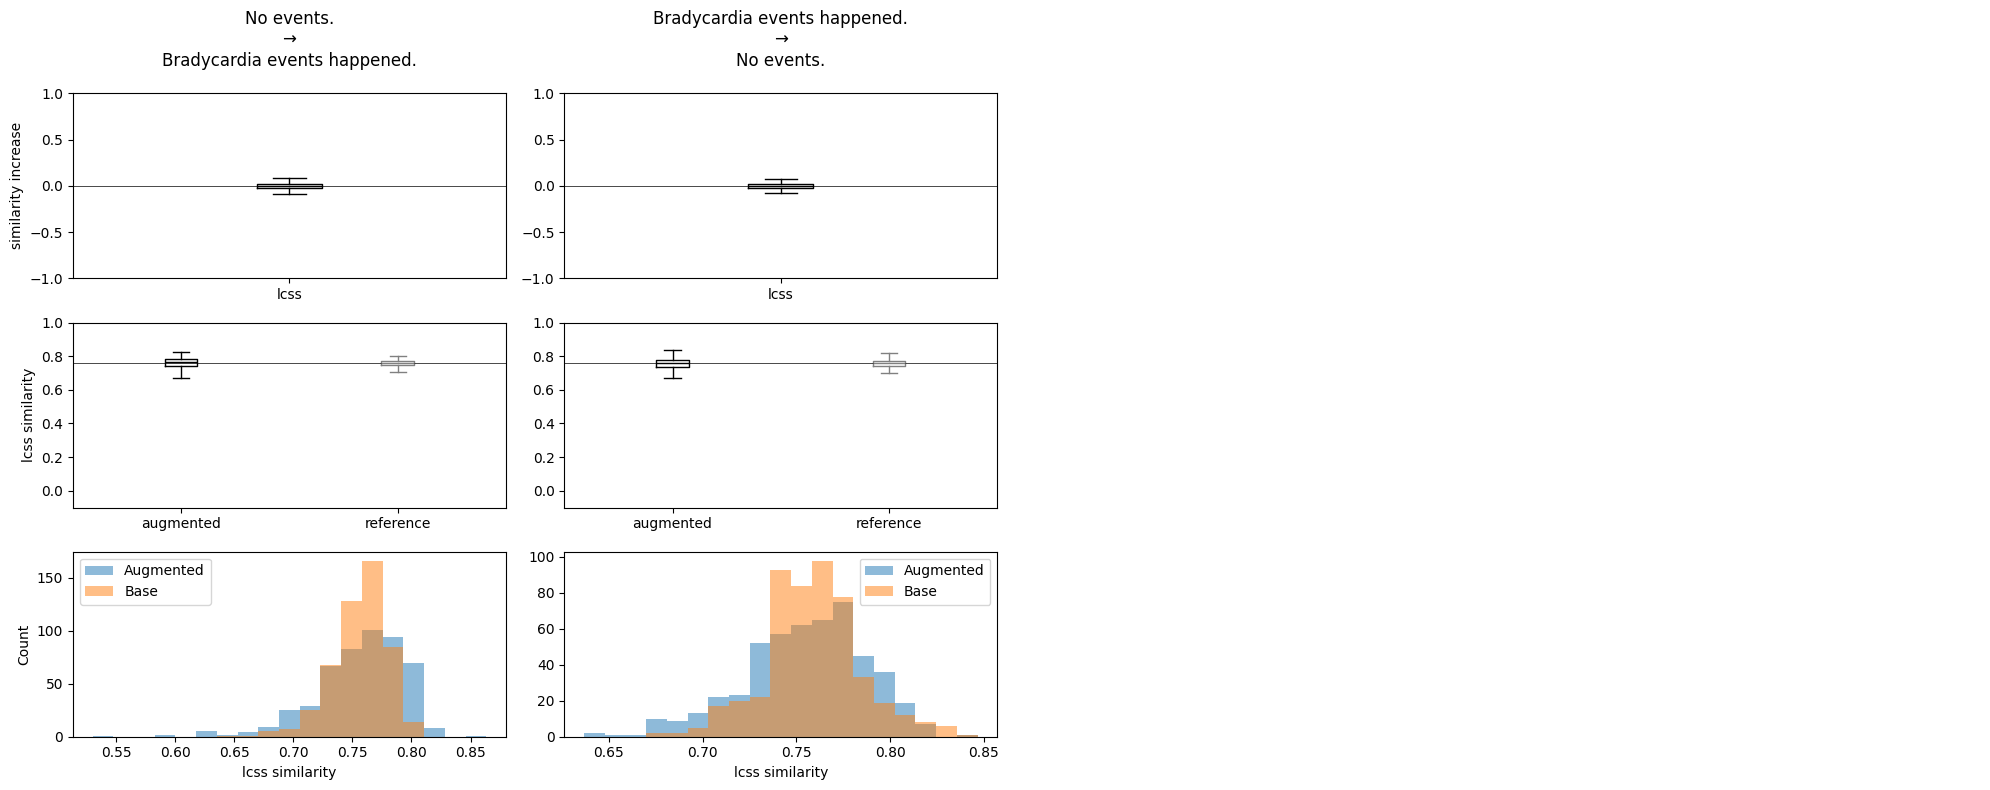

In [19]:
# Define the base augmentation pairs
base_aug_dict = {'description_succ_inc': [('Low amount of consecutive increases.', 'High amount of consecutive increases.'), 
                                        #   ('Moderate amount of consecutive increases.', 'High amount of consecutive increases.'),
                                        #   ('High amount of consecutive increases.', 'Moderate amount of consecutive increases.'),
                                          ('High amount of consecutive increases.', 'Low amount of consecutive increases.')],
                'description_histogram': [('Low variability.', 'High variability.'),
                                          ('High variability.', 'Low variability.')],
                'description_ts_event_binary': [('No events.', 'Bradycardia events happened.'),
                                                ('Bradycardia events happened.', 'No events.')]
                }
df_dists = pd.DataFrame()
for df in res_all[0]['dists_dict'].values():
    df_dists = pd.concat([df_dists, df], ignore_index=True)
# df_dists = res_all[0]['dists_dict']['segment1']
res_df = eng_dists_multiple(df_dists, base_aug_dict, metric = 'lcss')